In [1]:
SAVE = False

Utility plotting functions and node labels

In [ ]:
import sys
sys.path.append('..')
from typing import Optional
import numpy as np
import torch as tc
import matplotlib.pyplot as plt
from scipy import stats
from plotting.plot_circular_graph import plot_circular_graph
from plotting_styles import colors
import eval_reallabor_utils

import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import CONSTRUCTS_ANY_NON_CONDITIONAL as CONSTRUCTS
CONSTRUCTS = [c.lower() for c in CONSTRUCTS]
from feature_names import FLIP_OBSERVATION
NEGATIVE_ITEMS = [i for i in range(len(LABELS)) if LABELS[i] in FLIP_OBSERVATION]
from feature_names import GERMAN_EMA_LABELS as PRINT_LABELS

def plot_network_graph(networks: tc.Tensor, directed: bool=True, invert_negative: bool=False, hide_self_connections: bool=True,
                       alpha_level: float=0.01, fisher_transform: bool=False, edge_threshold: Optional[float]=None,
                       node_labels: Optional[list]=None, title: Optional[str]=None, ax: Optional[plt.Axes]=None):    

    if fisher_transform:
        networks = tc.arctanh(networks)
    sig_adj = tc.tensor(stats.ttest_1samp(networks, 0, axis=0).pvalue)   # Show only connections with a weight significantly different from 0
    if fisher_transform:
        networks = tc.tanh(networks)
    networks = tc.nanmean(networks, dim=0)
    if fisher_transform:
        networks = tc.tanh(networks)
    if hide_self_connections:
        for i in range(networks.shape[0]):
            networks[i,i] = 0
    max_abs = networks.abs().max()
    if invert_negative:
        networks[NEGATIVE_ITEMS, :] *= -1
        networks[:, NEGATIVE_ITEMS] *= -1

    networks_pos = networks * (networks > 0) * (sig_adj < alpha_level)
    networks_neg = networks * (networks < 0) * (sig_adj < alpha_level)
    max_pos = networks_pos.abs().max()
    max_neg = networks_neg.abs().max()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 6.27))
    ax.spines[['left', 'right', 'top', 'bottom']].set_visible(False)
    node_color = 'grey'
    plot_circular_graph(networks_pos, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_pos/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'k'}, node_kwargs={'node_color':node_color})
    plot_circular_graph(-networks_neg, directed=directed, labels=node_labels, ax=ax, max_edge_width=max_neg/max_abs * 3, labelpad=5,
                            edge_kwargs={'edge_color':'red'}, node_kwargs={'node_color':node_color})
    ax.set(xlim=(-2,2), ylim=(-2,2))
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    return ax, sig_adj


def plot_out_degree_centrality(networks: tc.Tensor, significant_only: bool=True, alpha_level: float=0.05,
                               node_labels: Optional[list]=None, ax: Optional[plt.Axes]=None):

    if significant_only:
        sig_adj = tc.tensor(stats.ttest_1samp(networks, 0, axis=0).pvalue)
        networks = networks * (sig_adj < alpha_level)
    out_degree_centrality = eval_reallabor_utils.weighted_degree_centrality(networks, mode='out', absolute=True)
    mean_centrality = tc.nanmean(out_degree_centrality, dim=0)
    sem_centrality = tc.nanmean((out_degree_centrality - mean_centrality)**2, dim=0) / np.sqrt(out_degree_centrality.shape[0])
    order = tc.argsort(mean_centrality, descending=True)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6.27, 2.5))
    ax.bar(range(len(mean_centrality)), mean_centrality[order], yerr=sem_centrality[order], color=colors.item_color_codes(np.array(LABELS)[order]))
    ax.set_ylabel('out-degree centrality')
    if node_labels is not None:
        node_labels = np.array(node_labels)
        ax.set_xticks(range(len(mean_centrality)), labels=node_labels[order], rotation=45, ha='right')
    return ax

PLRNN networks

/tmp/ipykernel_1113286/1546478855.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  networks = networks * (sig_adj < alpha_level)
/tmp/ipykernel_1113286/1546478855.py:66: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  networks = networks * (sig_adj < alpha_level)


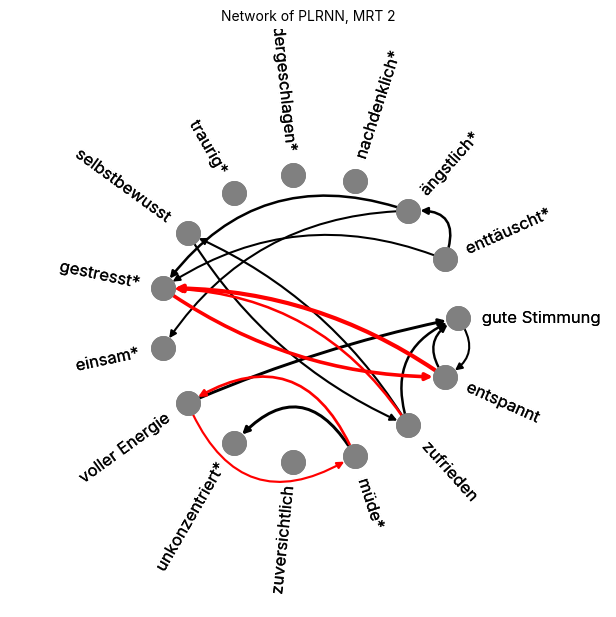

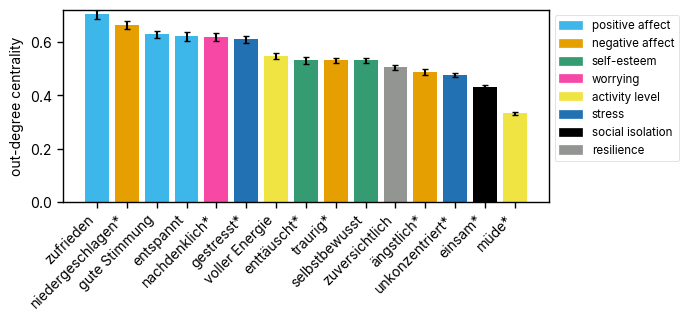

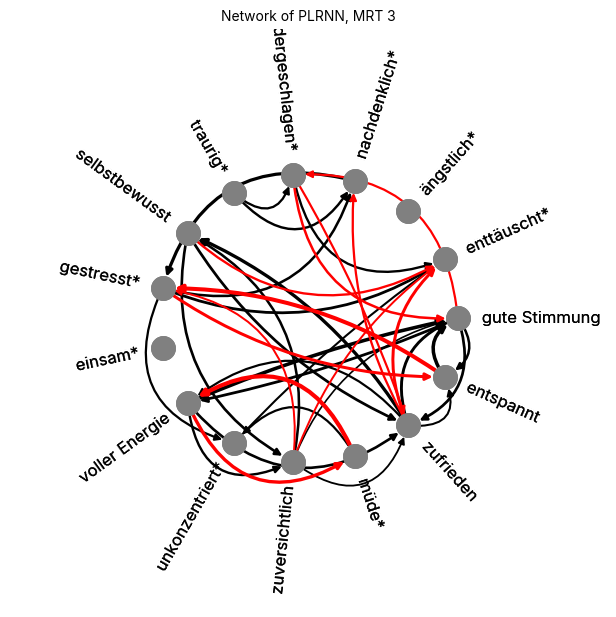

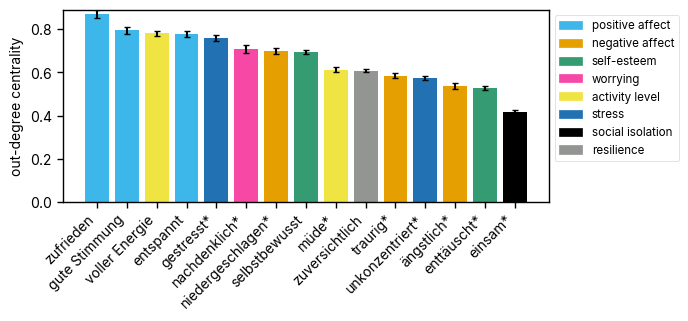

In [3]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
combined_eval_file = []
all_networks = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = PLRNN()
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
            networks.append(network)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of PLRNN, MRT {mrt}', alpha_level=0.05/(15**2), fisher_transform=False, invert_negative=True)
            # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn.png', dpi=300)
            # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_plrnn.svg', dpi=300)
            plot_out_degree_centrality(networks, node_labels=PRINT_LABELS)
            plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))
            # plt.savefig(f'../results/_paper/out_centrality_mrt_{mrt}_plrnn.png', dpi=300)
            all_networks.append(networks)
    plt.show()

KalmanFilter networks

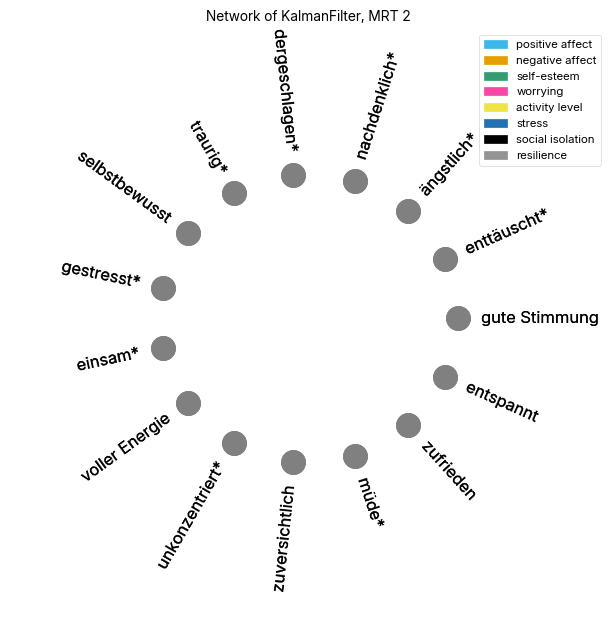

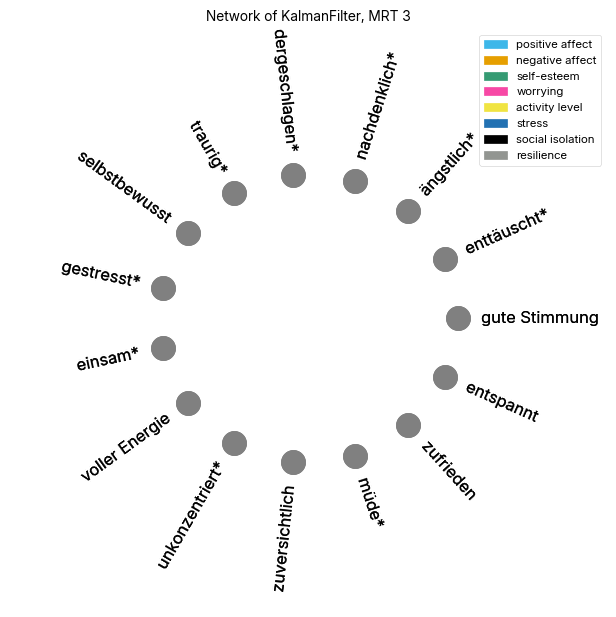

In [4]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter
MRT = [2, 3]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_Kalman_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = KalmanFilter(args)
            model.init_from_model_path(model_dir)
            network = eval_reallabor_utils.get_network_matrix(model)
            networks.append(network)
        
        if len(networks) > 0:
            if networks[0].ndim==2:
                networks = tc.stack(networks, dim=0)
            else:
                networks = tc.concat(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of KalmanFilter, MRT {mrt}', alpha_level=0.05, hide_self_connections=False)
            # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_{latent_model}.png', dpi=300)
            plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))

    plt.show()

Networks of VAR models

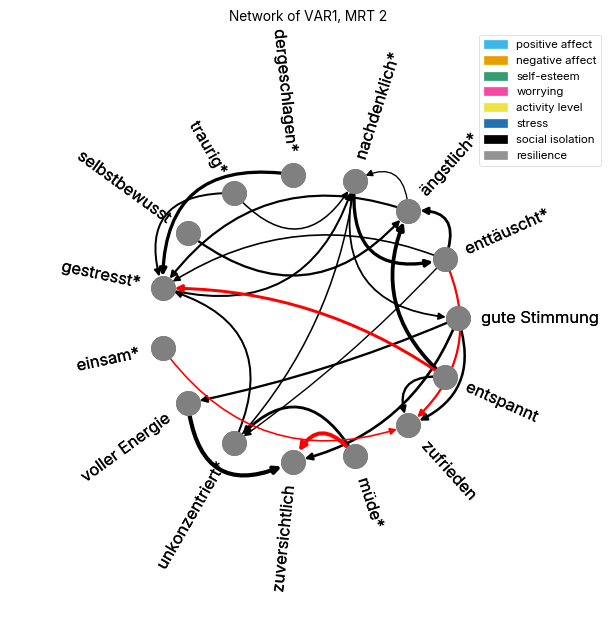

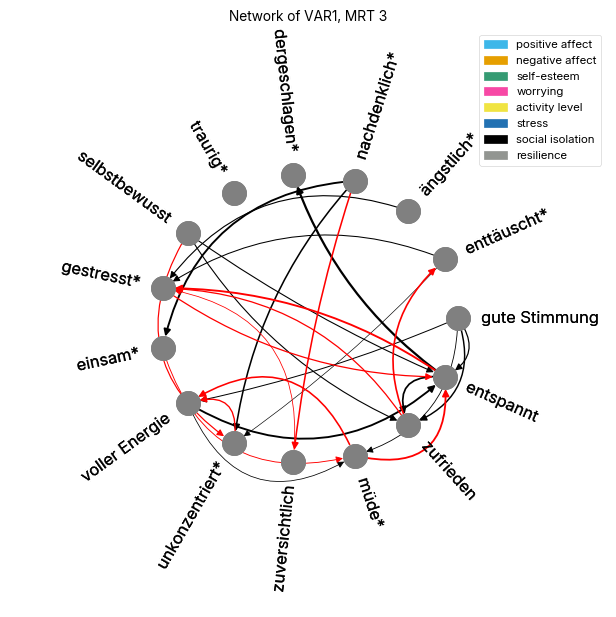

In [5]:
import sys
sys.path.append('..')
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import VAR1

MRT = [2,3]
combined_eval_file = []

with PaperStyle(settings={'axes.grid':False, 'axes.facecolor':'white'}):

    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_SimpleModels_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

        models = eval_reallabor_utils.ModelCatalogue(results_dir, latent_model='VAR1')
        data_files = data_utils.get_data_files(test_data_dir)
        participants = data_utils.get_participant_ids(data_files)
        networks = []
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = VAR1(args)
            model.init_from_model_path(model_dir)
            network = eval_reallabor_utils.get_network_matrix(model)
            networks.append(network)
        
        if len(networks) > 0:
            networks = tc.stack(networks, dim=0)
            plot_network_graph(networks, node_labels=PRINT_LABELS, title=f'Network of VAR1, MRT {mrt}', alpha_level=0.05, fisher_transform=False, invert_negative=True)
            # plt.savefig(f'../results/_paper/networks_mrt_{mrt}_VAR1.svg', dpi=300)
            plt.legend(*colors.construct_legend_handles_labels(*CONSTRUCTS), bbox_to_anchor=(1,1))

    plt.show()

Perturbation analysis

In [6]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
T = 7

# os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
with PaperStyle(settings={'axes.grid':False}):

    plrnn_out_centrality = []
    plrnn_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_out_centrality = []
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = PLRNN()
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
            model_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=False)
            perturb_nodes = tc.arange(len(model_out_centrality))
            model_params = model.get_parameters()
            B, C = model_params['B'], model_params['C']
            
            model_cir = []
            x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
            for i, item in enumerate(perturb_nodes):
                B_reduced = B[item]
                if B_reduced.ndim == 1:
                    B_reduced = B_reduced.unsqueeze(0)
                M = B_reduced @ C
                kernel_basis, compl_basis = eval_reallabor_utils.split_basis_into_kernel_and_orthogonal_complement(M)
                perturbation = compl_basis.mean(dim=1) * 1
                # perturbation 
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True, x0=x0).mean(axis=0)
                model_cir.append(subject_cir)
            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)
            mrt_out_centrality.append(model_out_centrality)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        plrnn_cir.append(mrt_cir)
        mrt_out_centrality = tc.stack(mrt_out_centrality, dim=0)
        plrnn_out_centrality.append(mrt_out_centrality)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


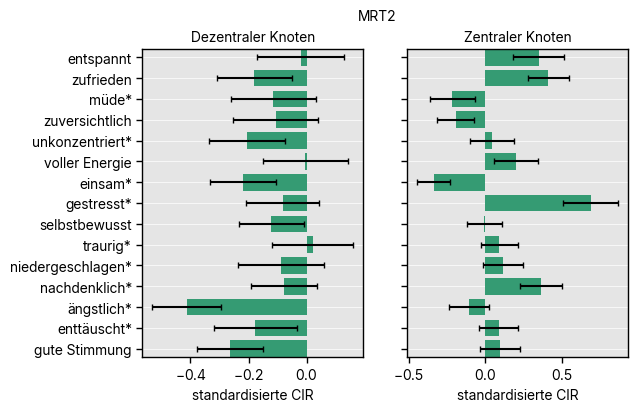

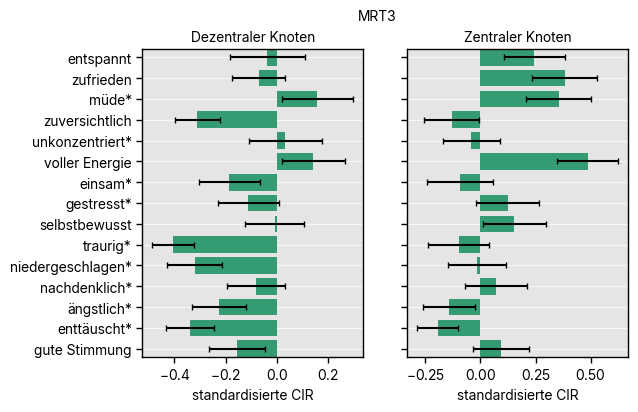

In [8]:
import math
from scipy import stats
import plotting_utils

take_absolute_cir = True
cir = plrnn_cir
out_centrality = plrnn_out_centrality

with PaperStyle():

    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 2, figsize=(6.27, 4), sharey=True, sharex=False)
        # valid_map = ~cir[m].mean(2).isnan().any(1)
        z_out_centrality = (out_centrality[m] - out_centrality[m].mean(1, keepdim=True)) / out_centrality[m].std(1, keepdim=True)  
        z_out_centrality = z_out_centrality
        if take_absolute_cir:
            abs_cir = tc.abs(cir[m])
            z_cir = (abs_cir - abs_cir.mean((1,2), keepdim=True)) / abs_cir.std((1,2), keepdim=True)
        else:
            z_cir = (cir[m] - cir[m].mean((1,2), keepdim=True)) / cir[m].std((1,2), keepdim=True)
        high_centrality_nodes = tc.argmax(z_out_centrality, dim=1)
        low_centrality_nodes = tc.argmin(z_out_centrality, dim=1)

        cir_of_high_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), high_centrality_nodes]
        cir_of_low_centrality_nodes = z_cir[tc.arange(z_cir.shape[0]), low_centrality_nodes]
        
        axes[0].barh(tc.arange(z_cir.shape[2]), cir_of_low_centrality_nodes.mean(0), xerr=stats.sem(cir_of_low_centrality_nodes, axis=0), color='#359B73')
        axes[0].set_yticks(range(z_cir.shape[2]), labels=PRINT_LABELS)
        axes[0].set(title=f'Dezentraler Knoten', xlabel='standardisierte CIR')
        axes[1].barh(tc.arange(z_cir.shape[2]), cir_of_high_centrality_nodes.mean(0), xerr=stats.sem(cir_of_high_centrality_nodes, axis=0), color='#359B73')
        axes[1].set_yticks(range(z_cir.shape[2]), labels=PRINT_LABELS)
        axes[1].set(title=f'Zentraler Knoten', xlabel='standardisierte CIR')
        fig.suptitle(f'MRT{mrt}')
        # fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_vs_out_centrality_mrt{mrt}.svg')
    plt.show()
